# Importing Necessary Packages

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Loading the Dataset

In [ ]:
database_path = "/app/input/supply_chain.db"

conn = sqlite3.connect(database_path)

# Looking at an overview of sales data
- From the time-series data of Product Sales, we observe that there is insufficient data from September 2019 onwards. Hence, we utilise 2015 data to train the model, and 2016 for testing.
- In terms of concept, our idea surrounds training on the sales data of the year before to forecast demand for the next year. This model aims at making predictions on the first day of every year.

In [5]:
query = '''
    SELECT "Order Year-Month", "Product Id", "Total Quantity Purchased"
    FROM cleaned_order_data;
'''

all_data = pd.read_sql_query(query, conn)

display(all_data.head())

Order Year-Month  Product Id  Total Quantity Purchased
0          2018-01        1360                         1
1          2018-01        1360                         1
2          2018-01        1360                         1
3          2018-01        1360                         1
4          2018-01        1360                         1

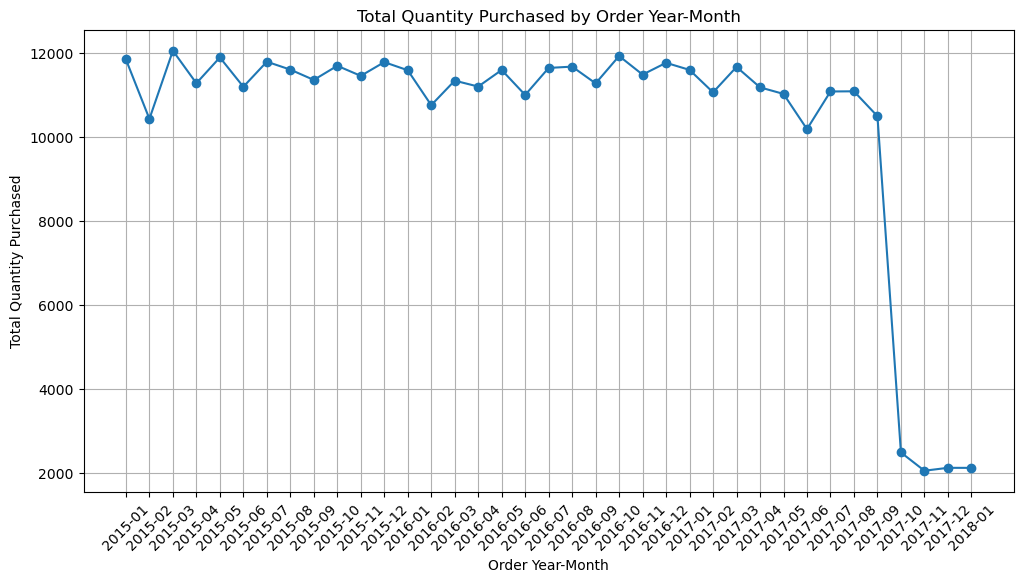

In [6]:
# Group the data by Order Year-Month and sum the Total Quantity Purchased
monthly_total_quantity = all_data.groupby('Order Year-Month')['Total Quantity Purchased'].sum().reset_index()

# Plotting the total quantity purchased by Order Year-Month
plt.figure(figsize=(12, 6))
plt.plot(monthly_total_quantity['Order Year-Month'], monthly_total_quantity['Total Quantity Purchased'], marker='o')
plt.xlabel('Order Year-Month')
plt.ylabel('Total Quantity Purchased')
plt.title('Total Quantity Purchased by Order Year-Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Data Preprocessing

For preprocessing, we make the folowing transformations: 
- Perform sine and cosine functions on Order Month, to obtain cyclic features for the model to recognise. I.e, to know that January follows after December
- Added in a column for "Quantity from previous month" as a feature 
- One Hot encoded the Product Id as they are categorical features. By doing so, we are able to make predictions for each individual product rather than just as a whole.

In [7]:
all_data_query = '''
SELECT "Order Year", "Order Month", "Product Id", SUM("Total Quantity Purchased") AS "Total Quantity Purchased"
FROM cleaned_order_data
WHERE "Order Year-Month" < '2017-01'
GROUP BY "Product Id", "Order Year-Month";
'''

all_data = pd.read_sql_query(all_data_query, conn)

display(all_data.head())

Order Year Order Month  Product Id  Total Quantity Purchased
0        2015     January          37                        18
1        2015    February          37                        20
2        2015       March          37                        13
3        2015       April          37                        32
4        2015         May          37                        25

In [8]:
# Copy and prepare data
processed_data = all_data.copy()

# Create the "Quantity from previous month" column
processed_data['Quantity from previous month'] = processed_data.groupby('Product Id')['Total Quantity Purchased'].shift(1)

# Encode Order Month as numeric and convert to account for cyclic features
month_mapping = {month: i+1 for i, month in enumerate(['January', 'February', 'March', 'April', 'May', 'June', 
                                                       'July', 'August', 'September', 'October', 'November', 'December'])}
processed_data['Order Month'] = processed_data['Order Month'].map(month_mapping)
processed_data['Month_sin'] = np.sin(2 * np.pi * processed_data['Order Month'] / 12)
processed_data['Month_cos'] = np.cos(2 * np.pi * processed_data['Order Month'] / 12)

# Remove rows with NaN values (from the shifted "Quantity from previous month")
processed_data = processed_data.dropna()

# Sort and One Hot Encode Product Id
processed_data = processed_data.sort_values(by=['Order Year', 'Order Month', 'Product Id'])
processed_data = processed_data.join(pd.get_dummies(processed_data['Product Id'], prefix='Product')).drop('Product Id', axis=1)

display(processed_data.head())

Order Year  Order Month  Total Quantity Purchased  \
1         2015            2                        20   
25        2015            2                        27   
49        2015            2                        20   
73        2015            2                        28   
97        2015            2                         9   

    Quantity from previous month  Month_sin  Month_cos  Product_37  \
1                           18.0   0.866025        0.5        True   
25                          50.0   0.866025        0.5       False   
49                          31.0   0.866025        0.5       False   
73                          44.0   0.866025        0.5       False   
97                          44.0   0.866025        0.5       False   

    Product_44  Product_93  Product_116  ...  Product_905  Product_906  \
1        False       False        False  ...        False        False   
25        True       False        False  ...        False        False   
49       False        True        False  ...        False        False   
73       False       False         True  ...        False        False   
97       False       False        False  ...        False        False   

    Product_917  Product_924  Product_926  Product_957  Product_977  \
1         False        False        False        False        False   
25        False        False        False        False        False   
49        False        False        False        False        False   
73        False        False        False        False        False   
97        False        False        False        False        False   

    Product_1004  Product_1014  Product_1073  
1          False         False         False  
25         False         False         False  
49         False         False         False  
73         False         False         False  
97         False         False         False  

[5 rows x 60 columns]

In [9]:
train_data = processed_data[processed_data["Order Year"] == 2015]
test_data = processed_data[processed_data["Order Year"] == 2016]

X_train = train_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
Y_train = train_data['Total Quantity Purchased']

X_test = test_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
Y_test = test_data['Total Quantity Purchased']

# Linear Regression

In [10]:
model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)

# Evaluate the Linear Regression model
model_score = model_LR.score(X_test, Y_test)
print(f"Model Score: {model_score}")

Model Score: 0.9951178605011639


## Prediction by actual quantity of previous month
- This prediction is done by feeding in the X_test values, inclusive of the actual "Quantity from previous month" values
- The Root Mean Squared Error is 33.83 and mean absolute percentage error is 0.3545. However, making predictions this way is not quite accurate, as we will never have actual "Quantity from previous month" values of the future months. As such, we move forward with rolling predictions in the next iteration.

In [11]:
# Predict the Total Quantity Purchased using the Linear Regression model
Y_pred = model_LR.predict(X_test)
rmse_LR = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Linear Regression): {rmse_LR}")
mape_LR = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Linear Regression): {mape_LR}")

Root Mean Squared Error (Linear Regression): 33.831126943479795
Mean Absolute Percentage Error (Linear Regression): 0.35452713549991605


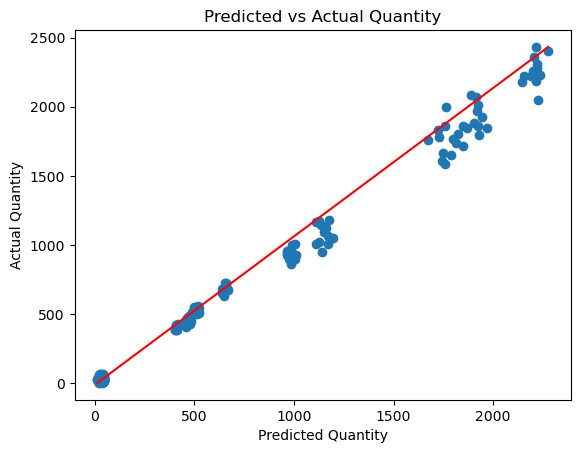

In [12]:
# Plotting the predicted vs actual quantity
plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

In [13]:
def plot_prediction_against_actual(test_data, Y_pred, product_id=None):
    if product_id is None:
        test_data['Predicted Quantity'] = Y_pred
        title = 'Actual vs Predicted Quantity Over Time by Month for all products'
    else:
        test_data = test_data[test_data[f'Product_{product_id}'] == True]
        test_data['Predicted Quantity'] = Y_pred
        title = f'Actual vs Predicted Quantity Over Time by Month for Product Id {product_id}'

    test_data = test_data.groupby('Order Month')[['Total Quantity Purchased', 'Predicted Quantity']].sum().reset_index()

    # Plotting the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['Order Month'].astype(str), test_data['Total Quantity Purchased'], label='Actual Quantity', color='blue')
    plt.plot(test_data['Order Month'].astype(str), test_data['Predicted Quantity'], label='Predicted Quantity', color='red', linestyle='--')
    plt.xlabel('Order Year-Month')
    plt.ylabel('Quantity Purchased')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/var/folders/cp/wwrr0w2x0vx65m4p2z4bn_080000gn/T/ipykernel_47138/331212338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Quantity'] = Y_pred


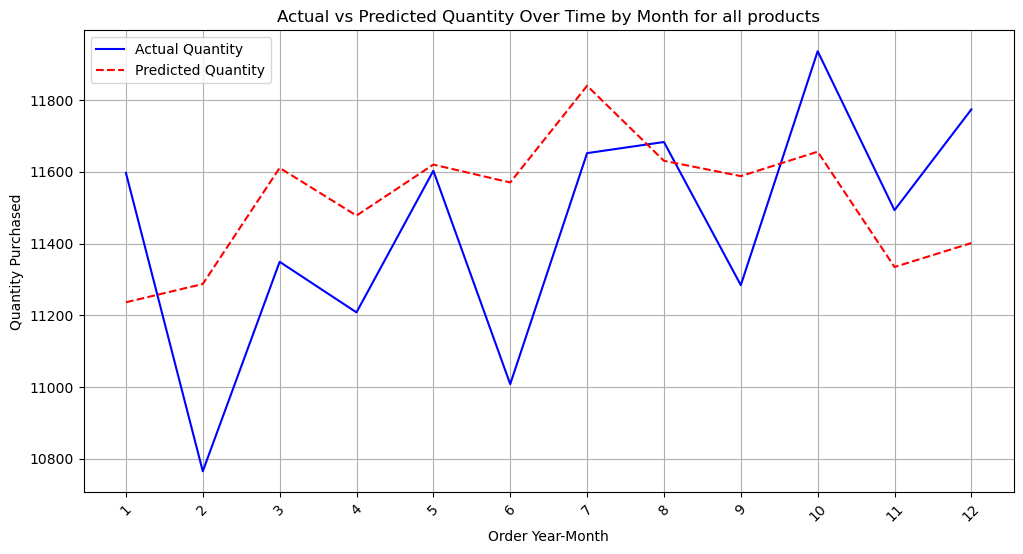

In [14]:
plot_prediction_against_actual(test_data, Y_pred)

## Rolling Predictions by month
- Rolling predictions mean to predict by month for the upcoming year. Essentially, we use the actual "Quantity from previous month" values only for the month of January as we will have the actual sales data of the month before (December).
- With the predictions made by the model for January, we use that as the "Quantity from previous month" values to make predictions for February, so on and so forth.
- For this linear regression model, we obtained a root mean squared error of 32.06 and mean absolute percentage error of 0.3255.

In [15]:
def convert_to_month(month_sin, month_cos):
    angle = np.arctan2(month_sin, month_cos)
    month = (angle / (2 * np.pi) * 12) % 12
    month = np.round(month).astype(int)
    month[month == 0] = 12  # Adjust for 0 to be December
    return month

# Forecasting for the entire year 2016
def forecast_demand(model, data, tolerance=1e-6):
    results = pd.DataFrame()
    previous_month_quantity = [None] * len(data[data['Month_sin'] == np.sin(2 * np.pi * (1 / 12))])

    for month in range(1, 13):
        month_sin = np.sin(2 * np.pi * (month / 12))
        month_cos = np.cos(2 * np.pi * (month / 12))

        # Filter data for the current month based on cyclical encoding with tolerance
        current_month_data = data[(np.abs(data['Month_sin'] - month_sin) < tolerance) & 
                                  (np.abs(data['Month_cos'] - month_cos) < tolerance)].copy()
        
        if month != 1:
            current_month_data['Quantity from previous month'] = previous_month_quantity

        prediction = model.predict(current_month_data)
        prediction = np.round(prediction)

        temp = pd.concat([current_month_data.reset_index(drop=True), pd.Series(prediction, name='Predicted Quantity')], axis=1)
        previous_month_quantity = prediction
        results = pd.concat([results, temp], ignore_index=True)

    results['Order Month'] = convert_to_month(results['Month_sin'], results['Month_cos'])

    return results

forecast_2016 = forecast_demand(model_LR, X_test)
display(forecast_2016.head())

Quantity from previous month  Month_sin  Month_cos  Product_37  Product_44  \
0                          39.0        0.5   0.866025        True       False   
1                          37.0        0.5   0.866025       False        True   
2                          29.0        0.5   0.866025       False       False   
3                          36.0        0.5   0.866025       False       False   
4                          46.0        0.5   0.866025       False       False   

   Product_93  Product_116  Product_134  Product_135  Product_172  ...  \
0       False        False        False        False        False  ...   
1       False        False        False        False        False  ...   
2        True        False        False        False        False  ...   
3       False         True        False        False        False  ...   
4       False        False         True        False        False  ...   

   Product_917  Product_924  Product_926  Product_957  Product_977  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   Product_1004  Product_1014  Product_1073  Predicted Quantity  Order Month  
0         False         False         False                17.0            1  
1         False         False         False                28.0            1  
2         False         False         False                25.0            1  
3         False         False         False                30.0            1  
4         False         False         False                22.0            1  

[5 rows x 59 columns]

Root Mean Squared Error (Linear Regression) for rolling predictions: 32.06210216223709
Mean Absolute Percentage Error (Linear Regression) for rolling predictions: 0.3255318156880777


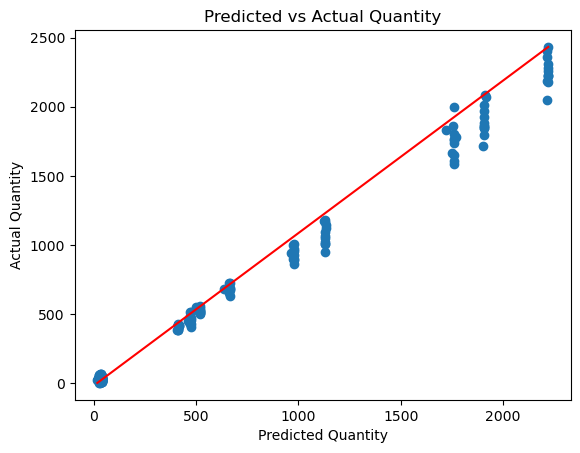

In [16]:
# Plotting the predicted vs actual quantity
Y_pred = forecast_2016['Predicted Quantity']
rmse_LR = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Linear Regression) for rolling predictions: {rmse_LR}")
mape_LR = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Linear Regression) for rolling predictions: {mape_LR}")

plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

In [17]:
def plot_rolling_prediction_against_actual(forecast, test_data, product_id=None):
    if product_id is None:
        title = 'Actual vs Predicted Quantity Over Time by Month for all products'
        forecast = forecast.groupby('Order Month')['Predicted Quantity'].sum().reset_index()
        test_data = test_data.groupby('Order Month')['Total Quantity Purchased'].sum().reset_index()
    else:
        forecast = forecast[forecast[f'Product_{product_id}'] == True]
        test_data = test_data[test_data[f'Product_{product_id}'] == True]
        title = f'Actual vs Predicted Quantity Over Time by Month for Product Id {product_id}'

    # Plotting the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['Order Month'].astype(str), test_data['Total Quantity Purchased'], label='Actual Quantity', color='blue')
    plt.plot(forecast['Order Month'].astype(str), forecast['Predicted Quantity'], label='Predicted Quantity', color='red', linestyle='--')
    plt.xlabel('Month')
    plt.ylabel('Quantity Purchased')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

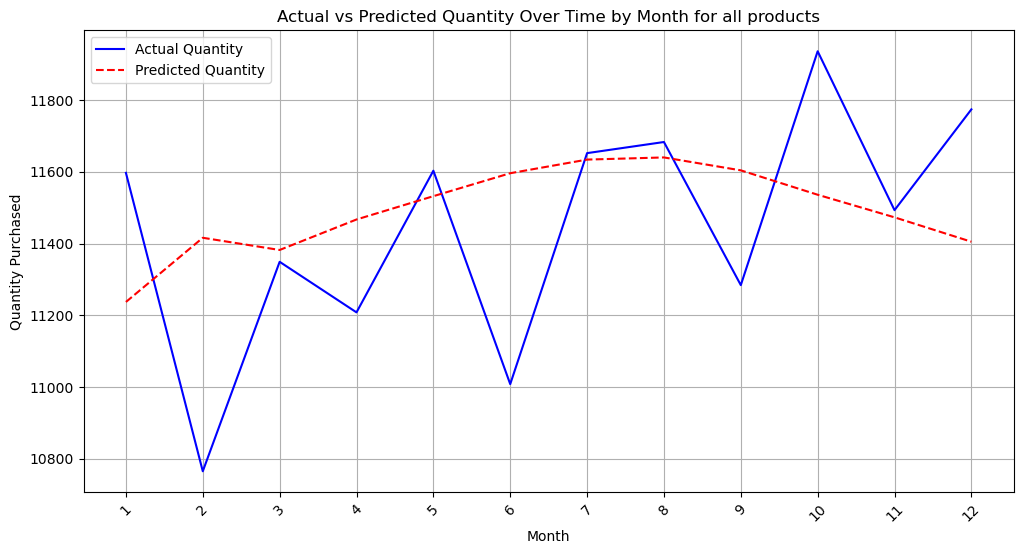

In [18]:
plot_rolling_prediction_against_actual(forecast_2016, test_data)

# Linear Regression with Exponentially Weighted Moving Average (EWMA)
- In this version, we experimented with an additional parameter: Exponentially Weighted Moving Average (EWMA).
- EWMA gives more weight to recent observations while diminishing the influence of older data, which makes it more responsive to shifts in data patterns and recent changes.
- The same preprocessing steps for the other features were made, and we used an EWMA weight of 0.5.
- However, our root mean squared error is higher than that of the regular linear regression with 46.15.


In [19]:
# Copy and prepare data
ewma_preprocessed_data = all_data.copy()

# Create the "Quantity from previous month" column
ewma_preprocessed_data['Quantity from previous month'] = ewma_preprocessed_data.groupby('Product Id')['Total Quantity Purchased'].shift(1)

# Encode Order Month as numeric and convert to cyclic features
month_mapping = {month: i+1 for i, month in enumerate(['January', 'February', 'March', 'April', 'May', 'June', 
                                                       'July', 'August', 'September', 'October', 'November', 'December'])}
ewma_preprocessed_data['Order Month'] = ewma_preprocessed_data['Order Month'].map(month_mapping)
ewma_preprocessed_data['Month_sin'] = np.sin(2 * np.pi * ewma_preprocessed_data['Order Month'] / 12)
ewma_preprocessed_data['Month_cos'] = np.cos(2 * np.pi * ewma_preprocessed_data['Order Month'] / 12)

# Remove rows with NaN values (from the shifted "Quantity from previous month")
ewma_preprocessed_data = ewma_preprocessed_data.dropna()

In [20]:
ewma_processed_data = ewma_preprocessed_data.copy()

# Calculate EWMA for "Total Quantity Purchased" by product
alpha = 0.5
ewma_processed_data['EWMA Quantity'] = ewma_processed_data.groupby('Product Id')['Total Quantity Purchased'] \
    .transform(lambda x: x.ewm(alpha=alpha).mean().shift(1))

# Sort and One Hot Encode Product Id
ewma_processed_data = ewma_processed_data.sort_values(by=['Order Year', 'Order Month', 'Product Id'])
ewma_processed_data = ewma_processed_data.join(pd.get_dummies(ewma_processed_data['Product Id'], prefix='Product')).drop('Product Id', axis=1)

# Drop any new NaN values introduced by EWMA calculation
ewma_processed_data = ewma_processed_data.dropna()

# Split data into training and testing sets
train_data = ewma_processed_data[ewma_processed_data["Order Year"] == 2015]
test_data = ewma_processed_data[ewma_processed_data["Order Year"] == 2016]

X_train = train_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
Y_train = train_data['Total Quantity Purchased']

X_test = test_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
Y_test = test_data['Total Quantity Purchased']

In [21]:
# Train model
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [22]:
# Function to convert month_sin and month_cos back to month
def convert_to_month(month_sin, month_cos):
    angle = np.arctan2(month_sin, month_cos)
    month = (angle / (2 * np.pi) * 12) % 12
    month = np.round(month).astype(int)
    month[month == 0] = 12  # Adjust for 0 to be December
    return month

def forecast_demand_with_ewma(model, data, alpha=0.5, tolerance=1e-6):
    results = pd.DataFrame()

    for month in range(1, 13):
        # Generate cyclical month features for the current month
        month_sin = np.sin(2 * np.pi * (month / 12))
        month_cos = np.cos(2 * np.pi * (month / 12))
        
        # Filter data for the current month based on cyclical encoding with tolerance
        current_month_data = data[(np.abs(data['Month_sin'] - month_sin) < tolerance) & 
                                  (np.abs(data['Month_cos'] - month_cos) < tolerance)].copy()
        
        # Use actual quantities from test_data for the first month
        if month == 1:
            previous_month_quantity = current_month_data['Quantity from previous month'].values
            ewma_quantity = current_month_data['Quantity from previous month'].ewm(alpha=alpha).mean().values
        else:
            # For subsequent months, use predictions from the previous month
            current_month_data['Quantity from previous month'] = previous_month_quantity
            current_month_data['EWMA Quantity'] = ewma_quantity

        # Prepare features for prediction
        features_for_prediction = current_month_data

        # Make predictions
        prediction = model.predict(features_for_prediction)
        prediction = np.round(prediction)

        # Store the predictions in a temporary DataFrame
        temp = pd.concat([current_month_data.reset_index(drop=True), pd.Series(prediction, name='Predicted Quantity')], axis=1)

        # Update `previous_month_quantity` and `ewma_quantity` for the next iteration
        previous_month_quantity = prediction
        ewma_quantity = alpha * prediction + (1 - alpha) * ewma_quantity

        # Append results
        results = pd.concat([results, temp], ignore_index=True)

    # Convert month_sin and month_cos back to month
    results['Order Month'] = convert_to_month(results['Month_sin'], results['Month_cos'])

    return results

# Run the forecast
forecast_2016_ewma = forecast_demand_with_ewma(model, X_test)
display(forecast_2016_ewma.head())


Quantity from previous month  Month_sin  Month_cos  EWMA Quantity  \
0                          39.0        0.5   0.866025      36.106497   
1                          37.0        0.5   0.866025      28.684416   
2                          29.0        0.5   0.866025      26.403517   
3                          36.0        0.5   0.866025      35.311187   
4                          46.0        0.5   0.866025      37.046898   

   Product_37  Product_44  Product_93  Product_116  Product_134  Product_135  \
0        True       False       False        False        False        False   
1       False        True       False        False        False        False   
2       False       False        True        False        False        False   
3       False       False       False         True        False        False   
4       False       False       False        False         True        False   

   ...  Product_917  Product_924  Product_926  Product_957  Product_977  \
0  ...        False        False        False        False        False   
1  ...        False        False        False        False        False   
2  ...        False        False        False        False        False   
3  ...        False        False        False        False        False   
4  ...        False        False        False        False        False   

   Product_1004  Product_1014  Product_1073  Predicted Quantity  Order Month  
0         False         False         False                19.0            1  
1         False         False         False                36.0            1  
2         False         False         False                31.0            1  
3         False         False         False                33.0            1  
4         False         False         False                28.0            1  

[5 rows x 60 columns]

Root Mean Squared Error (Linear Regression) for rolling predictions: 46.14936498901029
Mean Absolute Percentage Error (Linear Regression) for rolling predictions: 0.3634826968319673


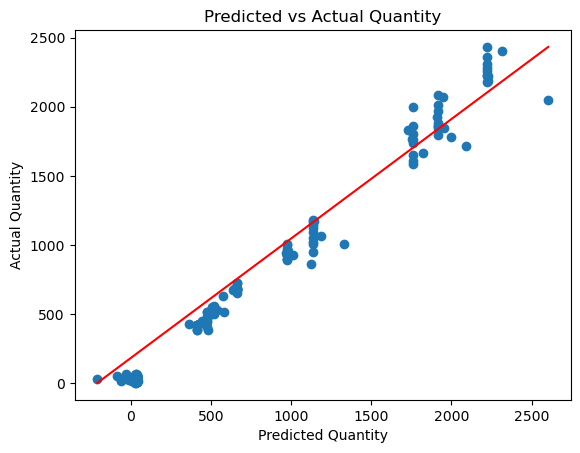

In [23]:
# Plotting the predicted vs actual quantity
Y_pred = forecast_2016_ewma['Predicted Quantity']
rmse_LR = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Linear Regression) for rolling predictions: {rmse_LR}")
mape_LR = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Linear Regression) for rolling predictions: {mape_LR}")

plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

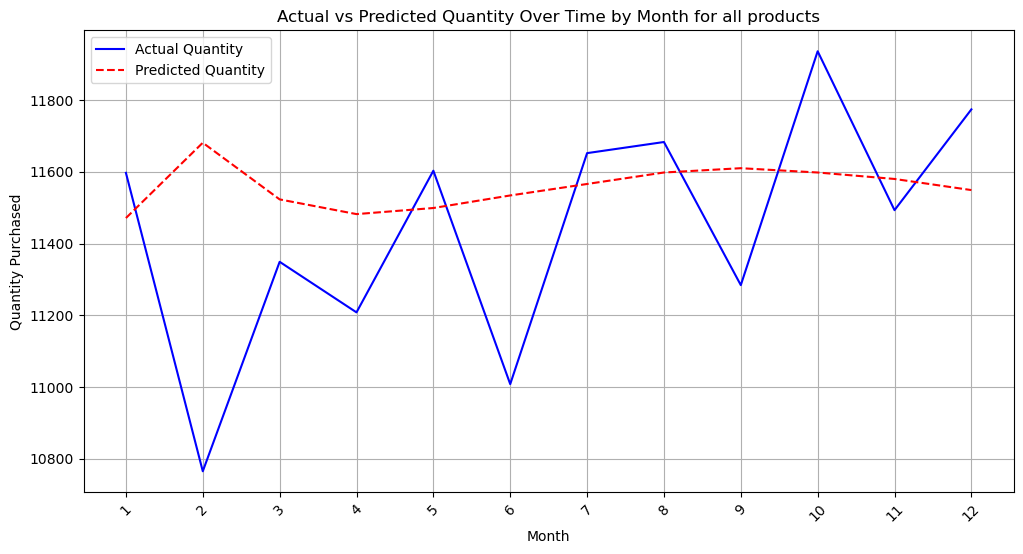

In [24]:
plot_rolling_prediction_against_actual(forecast_2016_ewma, test_data)

## Varying alpha value for EWMA
- We also experimented with varying values of alpha (weight) for this EWMA iteration.
- In doing so, we found that linear regression without EWMA performs better than with it.
- The lowest root mean squared error (32.32) was obtained with an alpha value of 1.0, and the lowest mean absolute percentage error (0.3255) was obtained with an alpha value of 0.3255.

In [25]:
ewma_processed_data = ewma_preprocessed_data.copy()

def process_alpha(data, alpha):
    # Calculate EWMA for "Total Quantity Purchased" by product
    data['EWMA Quantity'] = data.groupby('Product Id')['Total Quantity Purchased'] \
        .transform(lambda x: x.ewm(alpha=alpha).mean().shift(1))

    # Sort and One Hot Encode Product Id
    data = data.sort_values(by=['Order Year', 'Order Month', 'Product Id'])
    data = data.join(pd.get_dummies(data['Product Id'], prefix='Product')).drop('Product Id', axis=1)

    # Drop any new NaN values introduced by EWMA calculation
    data = data.dropna()

    # Split data into training and testing sets
    train_data = data[data["Order Year"] == 2015]
    test_data = data[data["Order Year"] == 2016]

    X_train = train_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
    Y_train = train_data['Total Quantity Purchased']

    X_test = test_data.drop(columns=['Total Quantity Purchased', 'Order Year', 'Order Month'])
    Y_test = test_data['Total Quantity Purchased']

    return X_train, Y_train, X_test, Y_test, test_data

def train_model(X_train, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)

    return model

def get_rmse(forecast, Y_test):
    Y_pred = forecast['Predicted Quantity']
    rmse_LR = mean_squared_error(Y_pred, Y_test, squared=False)

    return rmse_LR

def get_mape(forecast, Y_test):
    Y_pred = forecast['Predicted Quantity']
    mape_LR = mean_absolute_percentage_error(Y_test, Y_pred)

    return mape_LR

In [26]:
best_alpha1 = None
best_alpha2 = None

for alpha in np.arange(0.05, 1.05, 0.05):

    alpha = round(alpha, 2)
    X_train, Y_train, X_test, Y_test, test_data = process_alpha(ewma_processed_data, alpha)
    model = train_model(X_train, Y_train)
    forecast = forecast_demand_with_ewma(model, X_test, alpha=alpha)
    rmse = get_rmse(forecast, Y_test)
    mape = get_mape(forecast, Y_test)
    print(f"Alpha: {alpha}, RMSE: {rmse}", f"MAPE: {mape}")

    if best_alpha1 is None or rmse < best_rmse:
        best_alpha1 = alpha
        best_rmse = rmse

    if best_alpha2 is None or mape < best_mape:
        best_alpha2 = alpha
        best_mape = mape

print("\t")
print(f"Best Alpha: {best_alpha1}, Best RMSE: {best_rmse}")
print(f"Best Alpha: {best_alpha2}, Best MAPE: {best_mape}")

Alpha: 0.05, RMSE: 169.587048371356 MAPE: 1.4720895273828498
Alpha: 0.1, RMSE: 126.48468286713613 MAPE: 0.8849201769581994
Alpha: 0.15, RMSE: 101.68813525604574 MAPE: 0.6347620710304673
Alpha: 0.2, RMSE: 85.82972843922214 MAPE: 0.5298286164988816
Alpha: 0.25, RMSE: 74.66485819569147 MAPE: 0.4732189235939004
Alpha: 0.3, RMSE: 66.23188082062171 MAPE: 0.4358094829053145
Alpha: 0.35, RMSE: 59.60804330927575 MAPE: 0.4080275735119045
Alpha: 0.4, RMSE: 54.24211269966774 MAPE: 0.3894595095483377
Alpha: 0.45, RMSE: 49.81708827250562 MAPE: 0.3747475020534132
Alpha: 0.5, RMSE: 46.14936498901029 MAPE: 0.3634826968319673
Alpha: 0.55, RMSE: 43.081712484733984 MAPE: 0.35476124979500934
Alpha: 0.6, RMSE: 40.55180728492966 MAPE: 0.350163565451567
Alpha: 0.65, RMSE: 38.44051039601546 MAPE: 0.3456798706779048
Alpha: 0.7, RMSE: 36.74056106213531 MAPE: 0.3411459261811509
Alpha: 0.75, RMSE: 35.391396213287855 MAPE: 0.33793978078196896
Alpha: 0.8, RMSE: 34.284935323308645 MAPE: 0.33302884039085573
Alpha: 0.8

# Random Forest Classifier
- We also explored more complex models, such as random forest regressor. 
- This model performs slightly worse than linear regression, with a root mean squared error of 37.22 and a mean absolute percentage error of 0.3314.

In [27]:
train_data = processed_data[processed_data["Order Year"] == 2015]
test_data = processed_data[processed_data["Order Year"] == 2016]

X_train = train_data.drop(columns=['Order Year', 'Total Quantity Purchased', 'Order Month'])
Y_train = train_data['Total Quantity Purchased']

X_test = test_data.drop(columns=['Order Year', 'Total Quantity Purchased', 'Order Month'])
Y_test = test_data['Total Quantity Purchased']

In [28]:
model_RF = RandomForestRegressor(n_jobs=1)
model_RF.fit(X_train, Y_train)
model_RF.score(X_test, Y_test)


Y_pred = model_RF.predict(X_test)
rmse_RF = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Random Forest): {rmse_RF}")
mape_RF = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Random Forest): {mape_RF}")

Root Mean Squared Error (Random Forest): 37.2186273035989
Mean Absolute Percentage Error (Random Forest): 0.33136204297777433


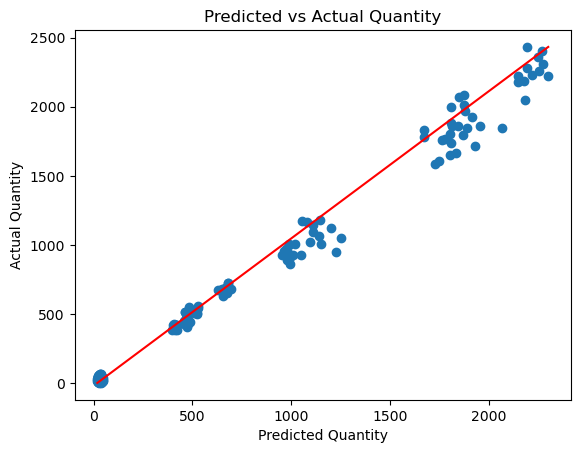

In [29]:
plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

/var/folders/cp/wwrr0w2x0vx65m4p2z4bn_080000gn/T/ipykernel_47138/331212338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Quantity'] = Y_pred


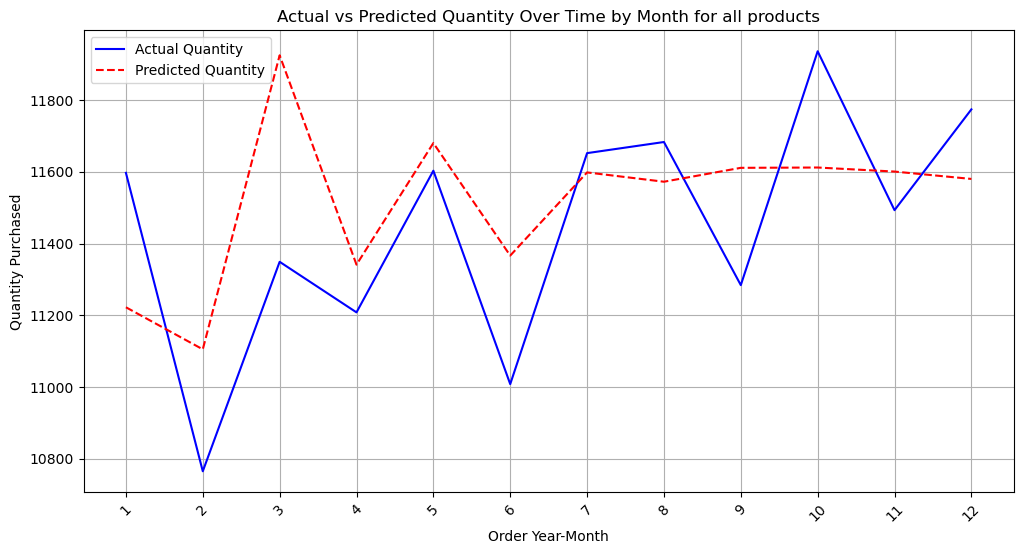

In [30]:
plot_prediction_against_actual(test_data, Y_pred)

## Grid search for best random forest parameters
- With more complex models, we also took the opportunity to perform hyperparameter tuning.
- However, it appears that this tuned model performs worse with a root mean squared error of 50.21 and a mean absolute percentage error of 0.4976.

In [31]:
param_grid = {
    'n_estimators': [100, 150, 200], 
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [4, 6, 10],
    'max_features': ['sqrt', 'log2', 0.2],
    'bootstrap': [True, False],
    'max_samples': [0.7, 0.8, 0.9]
}

model_RF = RandomForestRegressor(n_jobs=1, random_state=42)
grid_search = GridSearchCV(model_RF, param_grid, verbose=2, cv=3)
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.7, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END bootstra

/Users/robbs/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
2916 fits failed out of a total of 5832.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2916 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/robbs/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/robbs/anaconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/robbs/anaconda3/envs/machine_learning/lib/python3.8/site-p

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=1, random_state=42),
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', 0.2],
                         'max_samples': [0.7, 0.8, 0.9],
                         'min_samples_leaf': [4, 6, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [32]:
# Retrieve the best model from grid search
best_model_RF = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate on the test set
test_score = best_model_RF.score(X_test, Y_test)  # For regression, this is R^2
print("Test Score:", test_score)

Best Parameters: {'bootstrap': True, 'max_depth': 30, 'max_features': 0.2, 'max_samples': 0.9, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Test Score: 0.9896572702918587


Root Mean Squared Error (Random Forest) for rolling predictions: 50.207071215118695
Mean Absolute Percentage Error (Random Forest) for rolling predictions: 0.49763496595379186


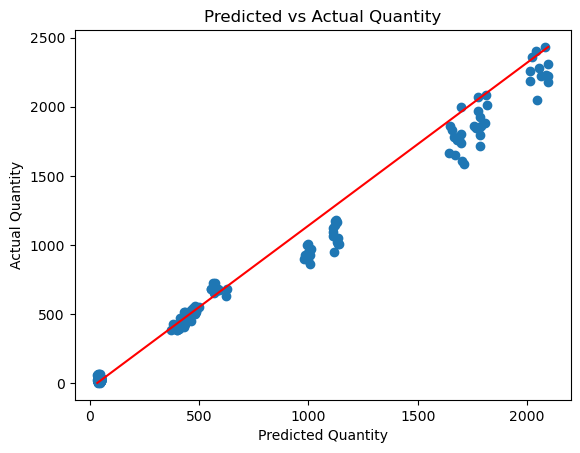

In [33]:
forecast_2016_RF = forecast_demand(best_model_RF, X_test)

# Plotting the predicted vs actual quantity
Y_pred = forecast_2016_RF['Predicted Quantity']
rmse_RF = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Random Forest) for rolling predictions: {rmse_RF}")
mape_RF = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Random Forest) for rolling predictions: {mape_RF}")

plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

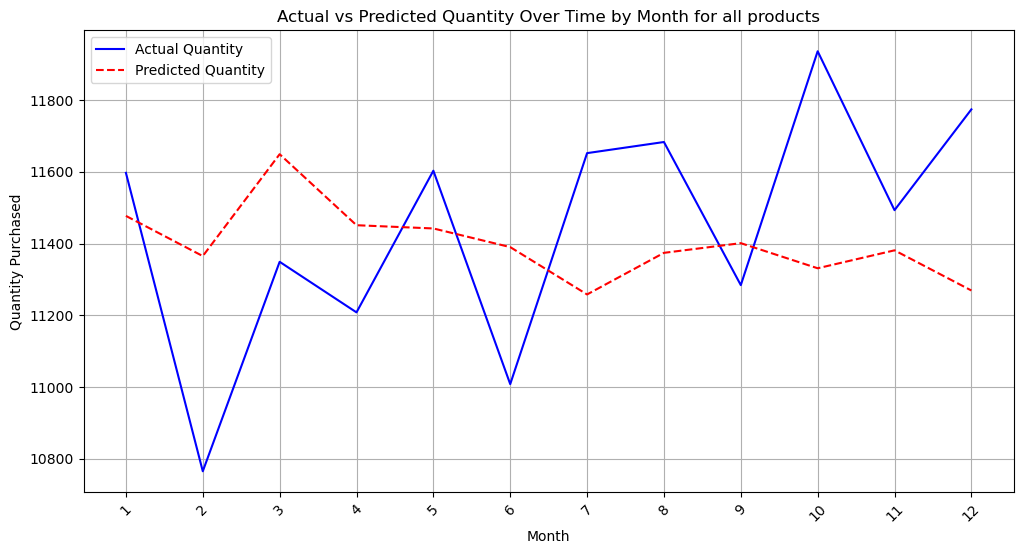

In [34]:
plot_rolling_prediction_against_actual(forecast_2016_RF, test_data)

# Gradient Boosting Regressor
- Our gradient boosting regressor model performs slightly better than the linear regression model with  a root mean squared error of 31.01 and a mean absolute percentage error of 0.3390
- The predictions follow the correct general trend of actual sales, albeit at differing magnitudes.

In [35]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],                # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # Controls the contribution of each tree
    'max_depth': [3, 5, 7, 10],                     # Controls the depth of each tree
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],                  # Minimum samples required at a leaf node
    'subsample': [0.7, 0.85, 1.0],                  # Fraction of samples used for each tree
    'max_features': ['sqrt', 'log2', None]          # Number of features to consider at each split
}


In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Instantiate the Gradient Boosting Regressor
model_gb = GradientBoostingRegressor(random_state=42)

# Setup GridSearchCV with the parameter grid
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5, verbose=2, n_jobs=-1)
grid_search_gb.fit(X_train, Y_train)

# Display best parameters
print("Best Parameters for GradientBoostingRegressor:", grid_search_gb.best_params_)


Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.85; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END 

In [37]:
# Retrieve the best model from grid search
best_model_GB = grid_search_gb.best_estimator_
print(f"Best Parameters: {grid_search_gb.best_params_}")

# Evaluate on the test set
test_score = best_model_GB.score(X_test, Y_test)  # For regression, this is R^2
print("Test Score:", test_score)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.85}
Test Score: 0.9949747506894766


Root Mean Squared Error (Gradient Boosting) for rolling predictions: 31.013263789291795
Mean Absolute Percentage Error (Gradient Boosting) for rolling predictions: 0.3389869248742221


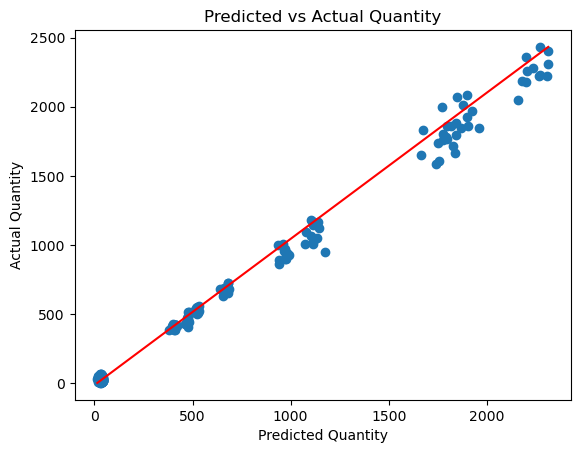

In [38]:
forecast_2016_GB = forecast_demand(best_model_GB, X_test)

# Plotting the predicted vs actual quantity
Y_pred = forecast_2016_GB['Predicted Quantity']
rmse_GB = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (Gradient Boosting) for rolling predictions: {rmse_GB}")
mape_GB = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (Gradient Boosting) for rolling predictions: {mape_GB}")

plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

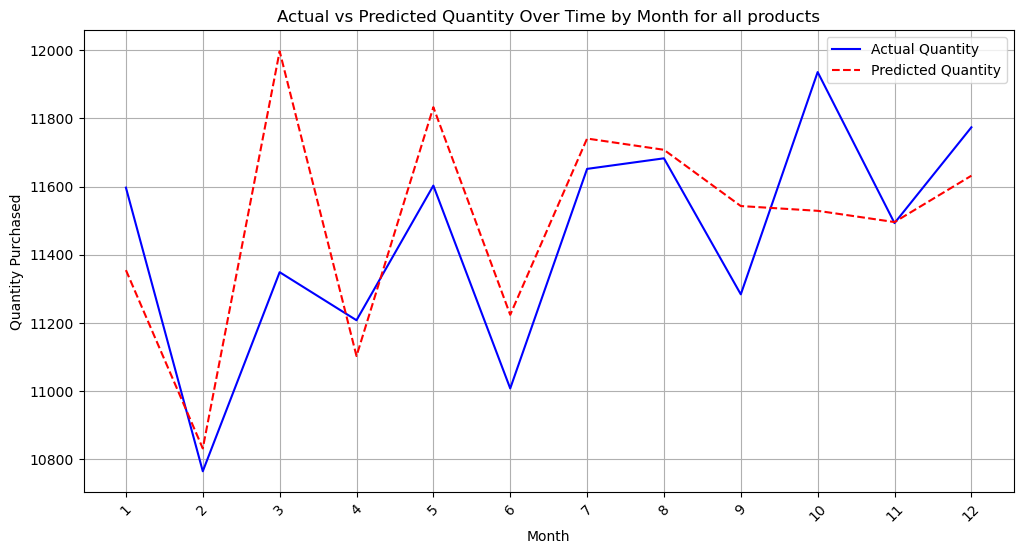

In [39]:
plot_rolling_prediction_against_actual(forecast_2016_GB, test_data)

## XGBoost Regressor
- Our XGBoost regressor performs worse with a root mean squared error if 63.44 and a mean absolute percentage error of 0.3432.
- While it follows the correct initial trend, the predictions for the second half of the year appear to stray further away from the actual values.

In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],            # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Step size shrinkage
    'max_depth': [3, 5, 7, 10],                 # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],              # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.7, 0.85, 1.0],              # Fraction of samples used for each boosting round
    'colsample_bytree': [0.7, 0.85, 1.0],       # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2]                      # Minimum loss reduction to make a split
}

In [41]:
# Initialize the XGBRegressor model
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, cv=5, verbose=2, n_jobs=-1)
grid_search_xgb.fit(X_train, Y_train)

# Print the best parameters found by grid search
print("Best Parameters for XGBRegressor:", grid_search_xgb.best_params_)


Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.85; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max

In [42]:
# Retrieve the best model from grid search
best_model_XGB = grid_search_xgb.best_estimator_

# Evaluate on the test set
test_score = best_model_XGB.score(X_test, Y_test)  # For regression, this is R^2
print("Test Score:", test_score)


Test Score: 0.9898012312857107


Root Mean Squared Error (XGB) for rolling predictions: 63.439603823899574
Mean Absolute Percentage Error (XGB) for rolling predictions: 0.34318684572603086


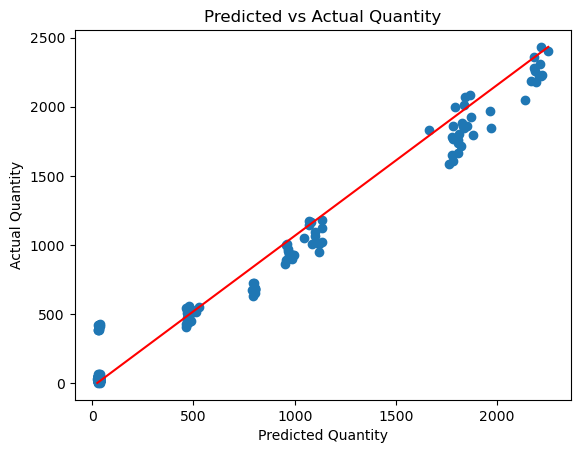

In [43]:
forecast_2016_XGB = forecast_demand(best_model_XGB, X_test)

# Plotting the predicted vs actual quantity
Y_pred = forecast_2016_XGB['Predicted Quantity']
rmse_XGB = mean_squared_error(Y_pred, Y_test, squared=False)
print(f"Root Mean Squared Error (XGB) for rolling predictions: {rmse_XGB}")
mape_XGB = mean_absolute_percentage_error(Y_test, Y_pred)
print(f"Mean Absolute Percentage Error (XGB) for rolling predictions: {mape_XGB}")

plt.scatter(Y_pred, Y_test)
plt.plot(np.linspace(Y_pred.min(), Y_pred.max()), np.linspace(Y_test.min(), Y_test.max()), color='red')
plt.xlabel('Predicted Quantity')
plt.ylabel('Actual Quantity')
plt.title('Predicted vs Actual Quantity')
plt.show()

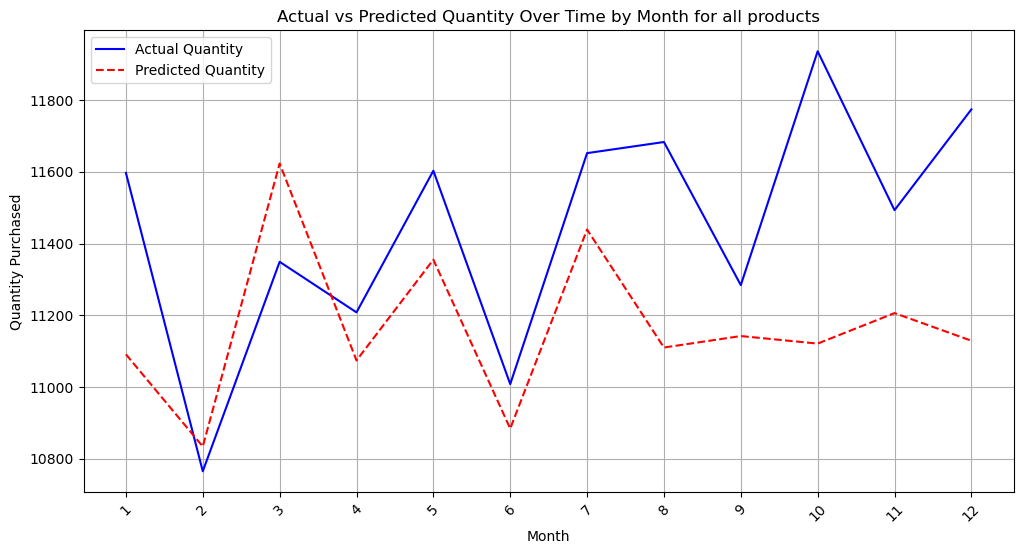

In [44]:
plot_rolling_prediction_against_actual(forecast_2016_XGB, test_data)

# Conclusion

We've explored a few different models, ranging from simple ones to complex ones to explore the accuracies of predicted sales data for the upcoming year. While regular linear regression performed well, we have decided to choose Gradient Boosting Regressor as our model choice. Apart from its low error values, we think that a complex model is suitable in capturing trends in products or seasonality that a linear regression model might not be able to capture.